In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import importlib

import utils.data_processing as data_processing
importlib.reload(data_processing)
from utils.data_processing import get_df

# running original modeling

In [4]:
# Load data
df = get_df()

# Logistic Model 
def logistic_model(delta_R, A, B, sigma):
    # A = Info Bonus, B = Spatial Bias, sigma = Decision Noise
    return 1 / (1 + np.exp(-(delta_R + A + B) / (np.sqrt(2) * sigma)))

In [5]:
def preprocess_horizon_per_subject(df):
    """
    Step 1: Prepares raw data for per-subject fitting.
    Uses 0=Left, 1=Right encoding as confirmed by your source code.
    """
    
    def process_row(row):
        # 1. Calculate Forced Trial Means (r0-r3)
        # Choice encoding: 0 = Left (Machine A), 1 = Right (Machine B)
        left_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 0]
        right_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 1]
        
        m_left = np.mean(left_vals)
        m_right = np.mean(right_vals)
        
        uc = row['uc']
        horizon = row['gameLength']
        choice = row['c4'] # Trial 5 (1st free choice)
        
        # 2. Unequal Condition Logic (uc = 1 or -1)
        # Goal: Align dx/dy to the High Information option [cite: 1092-1093]
        if uc != 0:
            cond = 'unequal'
            if uc == 1:  # [1 3] -> Left (0) played once. Left is High Info.
                dx = m_left - m_right
                dy = 1 if choice == 0 else 0
            else:        # [-1] -> [3 1] -> Right (1) played once. Right is High Info.
                dx = m_right - m_left
                dy = 1 if choice == 1 else 0
                
        # 3. Equal Condition Logic (uc = 0)
        # Goal: Align dx/dy to the Left option [cite: 267, 1093]
        else:
            cond = 'equal'
            dx = m_left - m_right
            dy = 1 if choice == 0 else 0
            
        return pd.Series([row['subject'], horizon, cond, dx, dy], 
                         index=['subject', 'horizon', 'condition', 'dx', 'dy'])

    # Process all rows and return the cleaned data for Layer 2
    return df.apply(process_row, axis=1)


In [6]:
def fit_subject_parameters(processed_df):
    """
    Layer 2: Fits logistic parameters for every subject individually.
    Stores results in a summary DataFrame.
    """
    subjects = processed_df['subject'].unique()
    results = []

    for sub in subjects:
        # We fit for each horizon separately
        for h in [1, 6]:
            # Filter data for this specific subject and horizon
            sub_data = processed_df[(processed_df['subject'] == sub) & 
                                    (processed_df['horizon'] == h)].dropna()
            
            if len(sub_data) < 5:  # Skip if not enough data for a stable fit
                continue

            try:
                # 1. Fit the model to this subject's unique behavior
                # p0: Initial guesses [A=5, B=0, sigma=8]
                popt, _ = curve_fit(logistic_model, sub_data['dx'], sub_data['dy'], 
                                   p0=[5, 0, 8], 
                                   bounds=([-60, -20, 0.1], [60, 20, 50]))
                
                A_val, B_val, sigma_val = popt
                
                results.append({
                    'subject': sub,
                    'horizon': h,
                    'condition': sub_data['condition'].iloc[0],
                    'A': A_val,
                    'B': B_val,
                    'sigma': sigma_val
                })
            except Exception as e:
                print(f"Fit failed for subject {sub}, horizon {h}: {e}")
                
    return pd.DataFrame(results)


In [7]:
# Execute Step 1
clean_data = preprocess_horizon_per_subject(df)
# Execute Fitting
subject_params = fit_subject_parameters(clean_data)

subject_params.to_csv('origin_subject_params.csv', index=False)
print(f"Successfully saved fitting results for {len(subject_params)} subject-horizon pairs.")


# plotting

In [9]:
subject_params = pd.read_csv('origin_subject_params.csv')

In [10]:
from scipy import stats

# 1. Define the common X-axis to match your bin range
x_range = np.linspace(-35, 35, 100)
averaged_curves = {}

# 2. Loop through conditions and horizons to calculate the mean strategies
for condition in ['unequal', 'equal']:
    for h in [1, 6]:
        # Filter parameters for this specific condition/horizon
        mask = (subject_params['condition'] == condition) & (subject_params['horizon'] == h)
        current_params = subject_params[mask]
        
        # Calculate the S-curve for every individual subject
        subject_y_values = []
        for _, p in current_params.iterrows():
            # Using the individual subject's fitted A, B, and sigma
            y_vals = logistic_model(x_range, p['A'], p['B'], p['sigma'])
            subject_y_values.append(y_vals)
        
        # Convert to array: shape (N_subjects, 100 points)
        subject_y_values = np.array(subject_y_values)
        
        # Calculate Grand Mean and SEM across subjects
        averaged_curves[(condition, h)] = {
            'x': x_range,
            'mean': np.mean(subject_y_values, axis=0),
            'sem': stats.sem(subject_y_values, axis=0)
        }

In [155]:

import utils.styles as styles
importlib.reload(styles)
from utils.styles import THEME, apply_base_style


def plot_choice_curve(ax, condition, averaged_curves, clean_data):
    """
    Plots the subject-averaged model lines and empirical dots for a given condition.
    """
    # 1. Setup Bins for Empirical Dots (-35 to 35)
    bins = [-35, -25, -15, -5, 5, 15, 25, 35]
    
    for h in [1, 6]:
        color = THEME['colors'][h]
        
        # --- PART A: THE MODEL LINE (From Step 1) ---
        data = averaged_curves[(condition, h)]
        ax.plot(data['x'], data['mean'], color=color, 
                lw=THEME['lines']['model_width'], label=f'H{h}')
        
        # Shaded SEM area
        ax.fill_between(data['x'], data['mean'] - data['sem'], 
                        data['mean'] + data['sem'], color=color, alpha=0.15)

        # --- PART B: THE EMPIRICAL DOTS ---
        sub = clean_data[(clean_data['condition'] == condition) & 
                         (clean_data['horizon'] == h)].copy()
        sub['bin'] = pd.cut(sub['dx'], bins=bins, labels=False, include_lowest=True)
        
        empirical = sub.groupby('bin').agg({'dy': ['mean', stats.sem], 'dx': 'mean'})
        
        ax.errorbar(empirical['dx']['mean'], empirical['dy']['mean'], 
                    yerr=empirical['dy']['sem'], fmt='o', color=color, 
                    capsize=3, markersize=8, alpha=0.6)

    # --- PART C: AXIS & STYLE ---
    x_label = 'R(high info) - R(low info)' if condition == 'unequal' else 'R(left) - R(right)'
    y_label = 'p(high info)' if condition == 'unequal' else 'p(left)'
    
    un = '[1 3]' if condition == 'unequal' else '[2 2]'
    ax.set_title(f'{condition} {un}', pad=30)
    ax.set_xlabel(f'\n{x_label}')
    ax.set_ylabel(y_label)
    
    # Specific Ticks and Limits
    ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
    ax.set_xlim(-35, 35)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(0, 1)
    
    # Reference lines
    ax.axhline(0.5, color='gray', lw=0.5, ls='--', alpha=0.5)
    ax.axvline(0, color='gray', lw=0.5, ls='--', alpha=0.5)
    
    # Apply global visual DNA
    ax.legend(frameon=True, loc='upper left', borderpad=0.8)
    apply_base_style(ax)

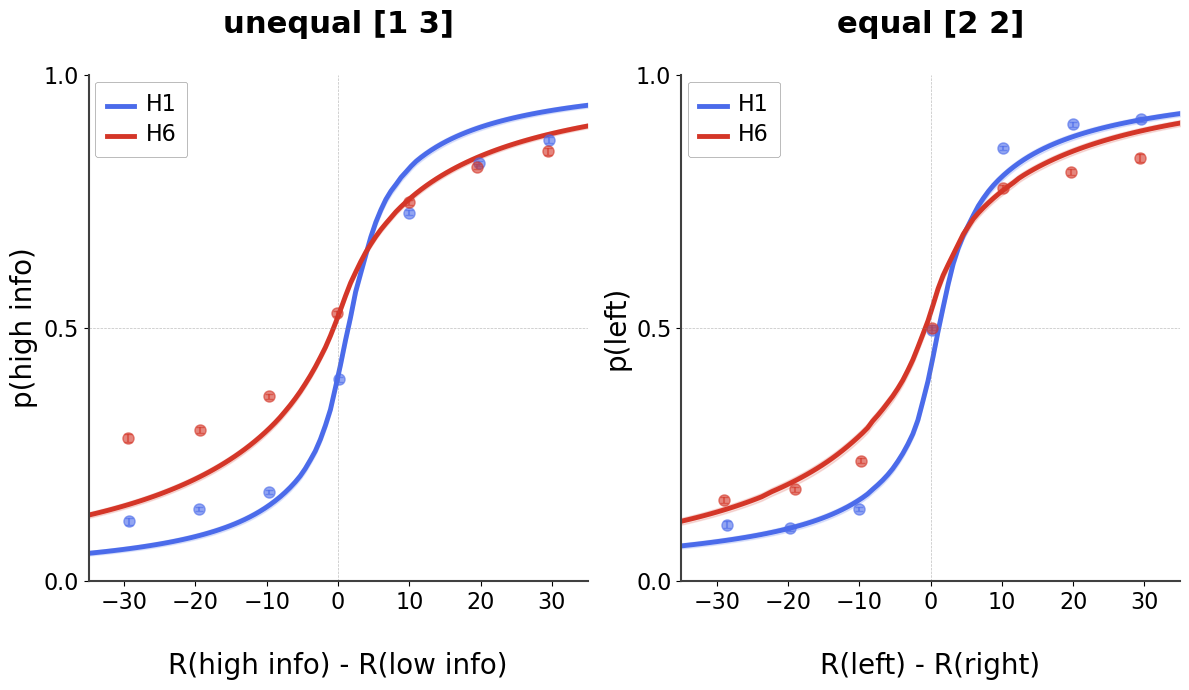

In [156]:
# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

# Plot the two distinct conditions using the same function
plot_choice_curve(axes[0], 'unequal', averaged_curves, clean_data)
plot_choice_curve(axes[1], 'equal', averaged_curves, clean_data)

plt.tight_layout()
plt.show()

In [104]:


# 1. Pivot the data so each subject has one row with H1 and H6 parameters side-by-side
# This automatically handles the "matching" for us
pivot_df = subject_params.pivot(index=['subject', 'condition'], columns='horizon', values=['A', 'sigma'])

# Flatten the multi-index columns (e.g., ('A', 1) becomes 'A_1')
pivot_df.columns = [f'{val}_{int(h)}' for val, h in pivot_df.columns]
pivot_df = pivot_df.reset_index().dropna() # Remove any subject missing one of the horizons

# 2. Define the configurations to match your pivot columns
configs = [
    {'h1_col': 'A_1',     'h6_col': 'A_6',     'cond': 'unequal', 'title': 'directed [1 3]', 'ylabel': 'information bonus'},
    {'h1_col': 'sigma_1', 'h6_col': 'sigma_6', 'cond': 'unequal', 'title': 'random [1 3]',   'ylabel': 'decision noise'},
    {'h1_col': 'sigma_1', 'h6_col': 'sigma_6', 'cond': 'equal',   'title': 'random [2 2]',   'ylabel': 'decision noise'}
]

processed_data = []

for cfg in configs:
    # Filter by condition first
    cond_data = pivot_df[pivot_df['condition'] == cfg['cond']]
    
    h1_vals = cond_data[cfg['h1_col']]
    h6_vals = cond_data[cfg['h6_col']]
    
    # Paired t-test will now work because shapes are guaranteed to match
    t_stat, p_val = stats.ttest_rel(h1_vals, h6_vals)
    
    processed_data.append({
        'h1': h1_vals.values,
        'h6': h6_vals.values,
        'p_val': p_val,
        'title': cfg['title'],
        'ylabel': cfg['ylabel']
    })

print(f"Stats processed for {len(pivot_df)} subjects with complete data.")

Stats processed for 753 subjects with complete data.


In [129]:
from matplotlib.ticker import MaxNLocator
def plot_param_bar(ax, data):
    """
    Plots clean bar charts with dynamic y-scaling and no scatter dots.
    """
    # 1. Plot Bars (Mean + SEM)
    h1_mean, h6_mean = data['h1'].mean(), data['h6'].mean()
    h1_sem, h6_sem   = stats.sem(data['h1']), stats.sem(data['h6'])
    
    ax.bar(['1', '6'], [h1_mean, h6_mean], yerr=[h1_sem, h6_sem], 
           width=0.6, color=[THEME['colors'][1], THEME['colors'][6]], 
           capsize=6, alpha=0.8, zorder=1)
    
    # 2. Dynamic Y-Axis Adjustment
    # Calculate a ceiling based on the max error bar height + 15% buffer
    current_max = max(h1_mean + h1_sem, h6_mean + h6_sem)
    
    # If there are stars, we need more room
    if data['p_val'] < 0.001:
        y_limit = current_max * 1.4  # Extra room for the significance bar/stars
    else:
        y_limit = current_max * 1.2
        
    ax.set_ylim(bottom=min(0, h1_mean, h6_mean) * 1.1, top=y_limit)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    # 3. Significance Annotation
    if data['p_val'] < 0.001:
        # Place star bar slightly above the highest error bar
        star_y = current_max * 1.3
        ax.plot([0, 1], [star_y, star_y], color=THEME['colors']['spine'], lw=1.5)
        ax.text(0.5, star_y, '***', ha='center', va='bottom', 
                fontsize=22, weight='bold')

    # 4. Labels & Style
    ax.set_title(data['title'], pad=10)
    ax.set_ylabel(data['ylabel'], labelpad=15)
    ax.set_xlabel('horizon', labelpad=10)
    
    # Apply the semibold, dark-spine, large-font style
    apply_base_style(ax)

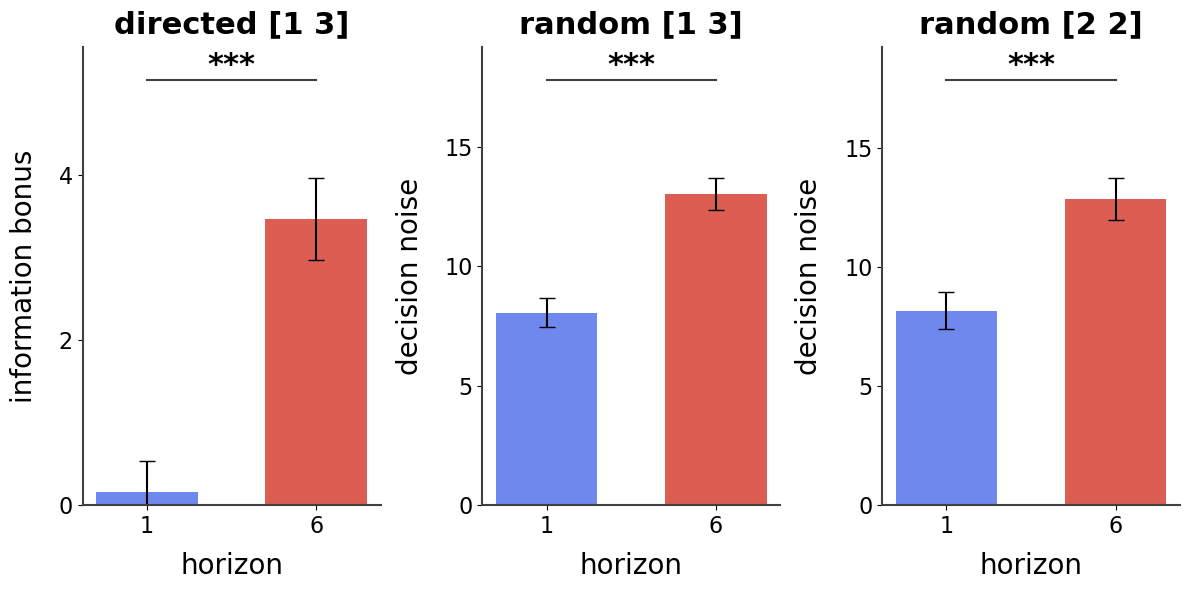

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i in range(3):
    plot_param_bar(axes[i], processed_data[i])

plt.tight_layout()
plt.show()